# Домашнее задание 4: проводим А/Б-тест
Цель: научиться проводить А/Б-тесты на Python

Задание:
1. Выберите две особенности в данных из приведенных ниже, сформулируйте для них гипотезы по всем правилам:
* В период Surge видим более низкую price-to-order конверсию
* Для устройств Android наблюдаем более высокие юзерские отмены
* Если Заказ из центра, то видим более низкие юзерские отмены
* Если Comfort & Business классы, то более низкие юзерские отмены, более длинные поездки
2. Разбейте юзеров на группы с помощью рандома, например, по следующему алгориму:
* Добавьте новую колонку, где каждому юзеру присвойте значение функции RAND() - выдает случайное число от 0 до 1
* В зависимости от значения rand - поместите пользователя в группу 1 или 2. (если rand >0.5, то 1, иначе 2)
3. Проверьте на однородность с помощью: рангового критерия (либо еще сложнее уровень) бакетинга/бутстрапа

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #visual
import random #random
import scipy.stats as stats #U-test

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netology-a-btesting-hw-1/Netology_A_B-testing_HW_1.csv


In [3]:
#загружаем файл с данными
df = pd.read_csv('../input/netology-a-btesting-hw-1/Netology_A_B-testing_HW_1.csv', sep=',')

In [4]:
#смотрим основную информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101500 entries, 0 to 101499
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         101500 non-null  int64  
 1   date               101500 non-null  object 
 2   user_id            101500 non-null  int64  
 3   hour               101500 non-null  int64  
 4   app_opened         101500 non-null  int64  
 5   price_seen         101500 non-null  int64  
 6   order_made         101500 non-null  int64  
 7   surge              91431 non-null   object 
 8   ride_completed     101500 non-null  int64  
 9   user_cancelled     101500 non-null  int64  
 10  age                101500 non-null  int64  
 11  os                 101500 non-null  object 
 12  city_center_order  101500 non-null  int64  
 13  order_class        101500 non-null  object 
 14  distance           91431 non-null   float64
 15  rfm                101500 non-null  object 
dtypes:

In [5]:
df.describe()

,Unnamed: 0,user_id,hour,app_opened,price_seen,order_made,ride_completed,user_cancelled,age,city_center_order,distance
count,101500.000000,101500.000000,101500.000000,101500.0,101500.000000,101500.000000,101500.000000,101500.000000,101500.000000,101500.000000,91431.000000
mean,50749.500000,549874.802207,11.481429,1.0,0.900798,0.731389,0.620365,0.111025,40.471764,0.571675,5.371152
std,29300.670499,258600.104176,6.917522,0.0,0.298934,0.443239,0.485299,0.314164,13.536322,0.494838,4.118531
min,0.000000,100093.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.010946
25%,25374.750000,328223.000000,5.000000,1.0,1.000000,0.000000,0.000000,0.000000,29.000000,0.000000,2.438335
50%,50749.500000,548827.000000,11.000000,1.0,1.000000,1.000000,1.000000,0.000000,40.000000,1.000000,4.279565
75%,76124.250000,773051.000000,17.000000,1.0,1.000000,1.000000,1.000000,0.000000,52.000000,1.000000,7.129814
max,101499.000000,999978.000000,23.000000,1.0,1.000000,1.000000,1.000000,1.000000,69.000000,1.000000,40.268966


In [6]:
df.head()

,Unnamed: 0,date,user_id,hour,app_opened,price_seen,order_made,surge,ride_completed,user_cancelled,age,os,city_center_order,order_class,distance,rfm
0,0,2020-05-21,867689,12,1,1,1,no surge,1,0,20,iOS,0,business,7.982135,low
1,1,2020-05-23,752172,5,1,1,1,no surge,1,0,37,Android,1,economy,2.908468,high
2,2,2020-05-20,486559,15,1,1,1,no surge,1,0,47,Android,0,comfort,7.224614,low
3,3,2020-05-19,304024,0,1,1,1,no surge,1,0,59,Android,1,economy,1.874349,low
4,4,2020-05-23,139420,0,1,1,1,no surge,1,0,19,Android,0,business,10.704778,medium


In [7]:
#создаем df по отменённым заказам
df_cancelled = df[df['user_cancelled']==1]
df_cancelled.describe()

,Unnamed: 0,user_id,hour,app_opened,price_seen,order_made,ride_completed,user_cancelled,age,city_center_order,distance
count,11269.000000,11269.000000,11269.000000,11269.0,11269.0,11269.0,11269.0,11269.0,11269.000000,11269.000000,11269.000000
mean,50738.019700,550824.891206,11.372438,1.0,1.0,1.0,0.0,1.0,43.477948,0.500222,5.098751
std,29127.774329,257984.931967,6.971733,0.0,0.0,0.0,0.0,0.0,15.020840,0.500022,3.918564
min,22.000000,100118.000000,0.000000,1.0,1.0,1.0,0.0,1.0,18.000000,0.000000,0.025761
25%,25649.000000,328222.000000,5.000000,1.0,1.0,1.0,0.0,1.0,30.000000,0.000000,2.314856
50%,51207.000000,552128.000000,11.000000,1.0,1.0,1.0,0.0,1.0,44.000000,1.000000,4.062219
75%,75864.000000,773497.000000,17.000000,1.0,1.0,1.0,0.0,1.0,57.000000,1.000000,6.700610
max,101493.000000,999878.000000,23.000000,1.0,1.0,1.0,0.0,1.0,69.000000,1.000000,31.475713


## Особенность 1: Для устройств Android наблюдаем более высокие юзерские отмены.
Гипотеза: Если мы снизим стоимость поездки на 5% для пользователей Android в выходные дни, то количество отмен сократится на 2%, потому что цена станет более привлекательной для клиента.

In [8]:
#Сводная таблица: кол-во уникальных пользователей по os
df_os_cancel = pd.pivot_table(df_cancelled, index="os", values="user_id", aggfunc='nunique', margins=False)
df_os_cancel.sort_values(by='user_id', ascending=False)

,user_id
os,
Android,6345
iOS,3601


([<matplotlib.patches.Wedge at 0x7f1a94e67410>,
 [Text(-0.4619214267977417, 0.9983128745364045, 'Android'),
  Text(0.46192133332894214, -0.9983129177846055, 'iOS')],
 [Text(-0.2519571418896772, 0.5445342952016751, '63.8%'),
  Text(0.25195709090669566, -0.544534318791603, '36.2%')])

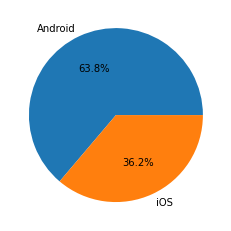

In [9]:
#Круговая диаграмма по ОС пользователей
plt.pie(df_os_cancel.user_id, labels=["Android", "iOS"], autopct="%1.1f%%")

### Разбиваем пользователей на группы для 1го теста

In [11]:
#фильтр для пользователей андроид
df_android = df[df['os'] == 'Android']
df_android

,Unnamed: 0,date,user_id,hour,app_opened,price_seen,order_made,surge,ride_completed,user_cancelled,age,os,city_center_order,order_class,distance,rfm
1,1,2020-05-23,752172,5,1,1,1,no surge,1,0,37,Android,1,economy,2.908468,high
2,2,2020-05-20,486559,15,1,1,1,no surge,1,0,47,Android,0,comfort,7.224614,low
3,3,2020-05-19,304024,0,1,1,1,no surge,1,0,59,Android,1,economy,1.874349,low
4,4,2020-05-23,139420,0,1,1,1,no surge,1,0,19,Android,0,business,10.704778,medium
5,5,2020-05-21,139455,5,1,0,0,NaN,0,0,60,Android,1,comfort,NaN,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101489,101489,2020-05-20,969159,22,1,0,0,NaN,0,0,67,Android,0,comfort,NaN,medium
101490,101490,2020-05-20,780673,20,1,1,0,surge,0,0,67,Android,1,comfort,5.439498,medium
101491,101491,2020-05-21,456333,10,1,1,1,no surge,1,0,34,Android,1,business,16.003392,high
101495,101495,2020-05-24,288445,16,1,1,1,no surge,1,0,29,Android,0,comfort,1.725907,high


In [13]:
#Сводная таблица по пользователям-android и среднему количеству отмен.
#Поскольку в выбранной выше гипотезе идёт речь об отменах, 
#то для последующего теста на однородность берём среднее количество отмен по каждому пользователю
df_android_mean_cancel = pd.pivot_table(df_android, index='user_id', values='user_cancelled', aggfunc='mean')
df_android_mean_cancel

,user_cancelled
user_id,
100093,0.000000
100118,0.500000
100134,0.250000
100166,0.250000
100255,0.250000
...,...
999870,0.500000
999878,0.333333
999945,0.000000


In [15]:
#Разбиваем юзеров на группы рандомно
df_android_mean_cancel['rand'] = 0.0

for i in range(len(df_android_mean_cancel)):
    t = random.random()
    df_android_mean_cancel['rand'].values[i] = t
    
df_android_mean_cancel['group'] = df_android_mean_cancel['rand'].apply(lambda x: '1' if x<0.5 else '2')
df_android_mean_cancel

,user_cancelled,rand,group
user_id,,,
100093,0.000000,0.410817,1
100118,0.500000,0.490926,1
100134,0.250000,0.373234,1
100166,0.250000,0.415336,1
100255,0.250000,0.005611,1
...,...,...,...
999870,0.500000,0.876906,2
999878,0.333333,0.971372,2
999945,0.000000,0.188111,1


In [16]:
#смотрим длину групп 1 и 2
len(df_android_mean_cancel[df_android_mean_cancel['group']=='1']), len(df_android_mean_cancel[df_android_mean_cancel['group']=='2'])

(11248, 10906)

In [19]:
#Приводим к одинаковой длине в 10900 юзеров
group_1a = df_android_mean_cancel[df_android_mean_cancel['group']=='1'].sample(10900)
group_2a = df_android_mean_cancel[df_android_mean_cancel['group']=='2'].sample(10900)

### Проверка групп 1 и 2 на однородность (Критерий Манна-Уитни) для 1го теста

Н0: группы 1 и 2 однородные

Н1: группы 1 и 2 имеют значимые различия

In [20]:
#Проверка на однородность U-test
stat, p = stats.mannwhitneyu(group_1a['user_cancelled'], group_2a['user_cancelled'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# интерпретация
alpha = 0.05
if p > alpha:
	print('Однородное распределение (не отклоняем Н0)')
else:
	print('Различное распределение (отклоняем Н0)')

Statistics=59899645.000, p=0.182
Однородное распределение (не отклоняем Н0)


### Особенность 2: Если Заказ из центра, то видим более низкие юзерские отмены
Гипотеза: Если мы увеличим стоимость поездки на 5%, для заказов из центра города, в будние дни, то наша выручка увеличится на 5%, потому что выручка с одного заказа увеличится, а количество отмен существенно не возрастёт.

In [21]:
#Сводная таблица: количество отменённых заказов из центра и не из центра
df_centre_cancel = pd.pivot_table(df, index='city_center_order', columns='user_cancelled',values='user_id', aggfunc='count', margins=False)
df_centre_cancel

user_cancelled,0,1
city_center_order,,
0,37843,5632
1,52388,5637


<AxesSubplot:xlabel='city_center_order'>

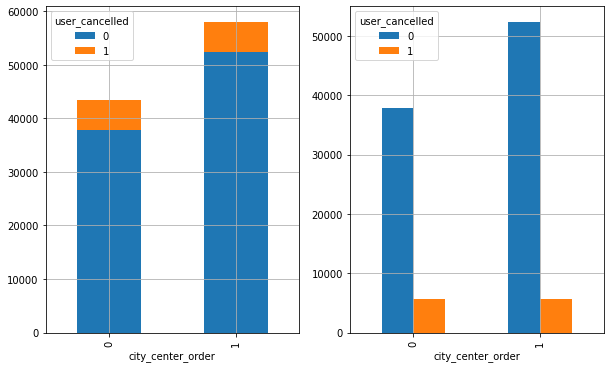

In [22]:
#2 варианта столбчатых диаграмм для отменённых заказов из центра / не из центра
fig,axes = plt.subplots(1,2,figsize = (10,6))
df_centre_cancel.plot(kind = 'bar',stacked = True,grid = True,ax = axes[0])
df_centre_cancel.plot(kind = 'bar',stacked = False,grid = True,ax = axes[1])

### Разбиваем пользователей на группы для 2го теста

In [23]:
#Сводная таблица по всем юзерам и среднему количеству отмен.
#Поскольку в выбранной выше гипотезе идёт речь об отменах, 
#то для последующего теста на однородность берём среднее количество отмен по каждому пользователю 
df_users_mean_cancel = pd.pivot_table(df, index='user_id', values='user_cancelled', aggfunc='mean')
df_users_mean_cancel

,user_cancelled
user_id,
100093,0.000000
100118,0.200000
100134,0.200000
100166,0.200000
100255,0.111111
...,...
999870,0.500000
999878,0.142857
999945,0.000000


In [24]:
#Разбиваем юзеров на группы рандомно
df_users_mean_cancel['rand'] = 0.0

for i in range(len(df_users_mean_cancel)):
    t = random.random()
    df_users_mean_cancel['rand'].values[i] = t
    
df_users_mean_cancel['group'] = df_users_mean_cancel['rand'].apply(lambda x: '1' if x<0.5 else '2')
df_users_mean_cancel

,user_cancelled,rand,group
user_id,,,
100093,0.000000,0.940093,2
100118,0.200000,0.509627,2
100134,0.200000,0.096651,1
100166,0.200000,0.934904,2
100255,0.111111,0.114096,1
...,...,...,...
999870,0.500000,0.379117,1
999878,0.142857,0.960915,2
999945,0.000000,0.851775,2


In [25]:
#смотрим длину групп 1 и 2
len(df_users_mean_cancel[df_users_mean_cancel['group']=='1']), len(df_users_mean_cancel[df_users_mean_cancel['group']=='2'])

(12075, 12149)

In [26]:
#Приводим к одинаковой длине в 12000 юзеров
group_1c = df_users_mean_cancel[df_users_mean_cancel['group']=='1'].sample(12000)
group_2c = df_users_mean_cancel[df_users_mean_cancel['group']=='2'].sample(12000)

### Проверка групп 1 и 2 на однородность (Критерий Манна-Уитни) для 2го теста

Н0: группы 1 и 2 однородные

Н1: группы 1 и 2 имеют значимые различия

In [27]:
#Проверка на однородность U-test
stat, p = stats.mannwhitneyu(group_1c['user_cancelled'], group_2c['user_cancelled'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# интерпретация
alpha = 0.05
if p > alpha:
	print('Однородное распределение (не отклоняем Н0)')
else:
	print('Различное распределение (отклоняем Н0)')

Statistics=71999355.000, p=0.999
Однородное распределение (не отклоняем Н0)
